# 07 - Visualization Library

**Purpose**: Create publication-quality charts for the presentation.

**Tips**:
- Every chart should have a clear insight as the title
- Use colorblind-friendly palettes
- Large fonts (readable from back of room)
- Export as high-res PNG for slides

**Chart Ideas**:
1. Card win rate bar chart (Top 15)
2. Trophy distribution histogram (showing "walls")
3. Deck archetype performance comparison
4. Card synergy network diagram
5. Feature importance from model
6. Elixir cost vs win rate scatter
7. Trophy progression by arena

In [1]:
import sys, os, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

from visualization import (
    setup_presentation_style, save_figure,
    plot_win_rate_comparison, plot_distribution,
    plot_scatter_with_regression, plot_correlation_heatmap
)

setup_presentation_style()

# Ensure output directory exists
os.makedirs(os.path.join(PROJECT_ROOT, 'presentation/figures'), exist_ok=True)

✓ Presentation style configured


## Chart 1: Feature Importance from Model

Shows which deck characteristics matter most for winning

⚠ Feature importance data not found. Run notebook 06 first.
  Creating placeholder chart...


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig1_feature_importance.png


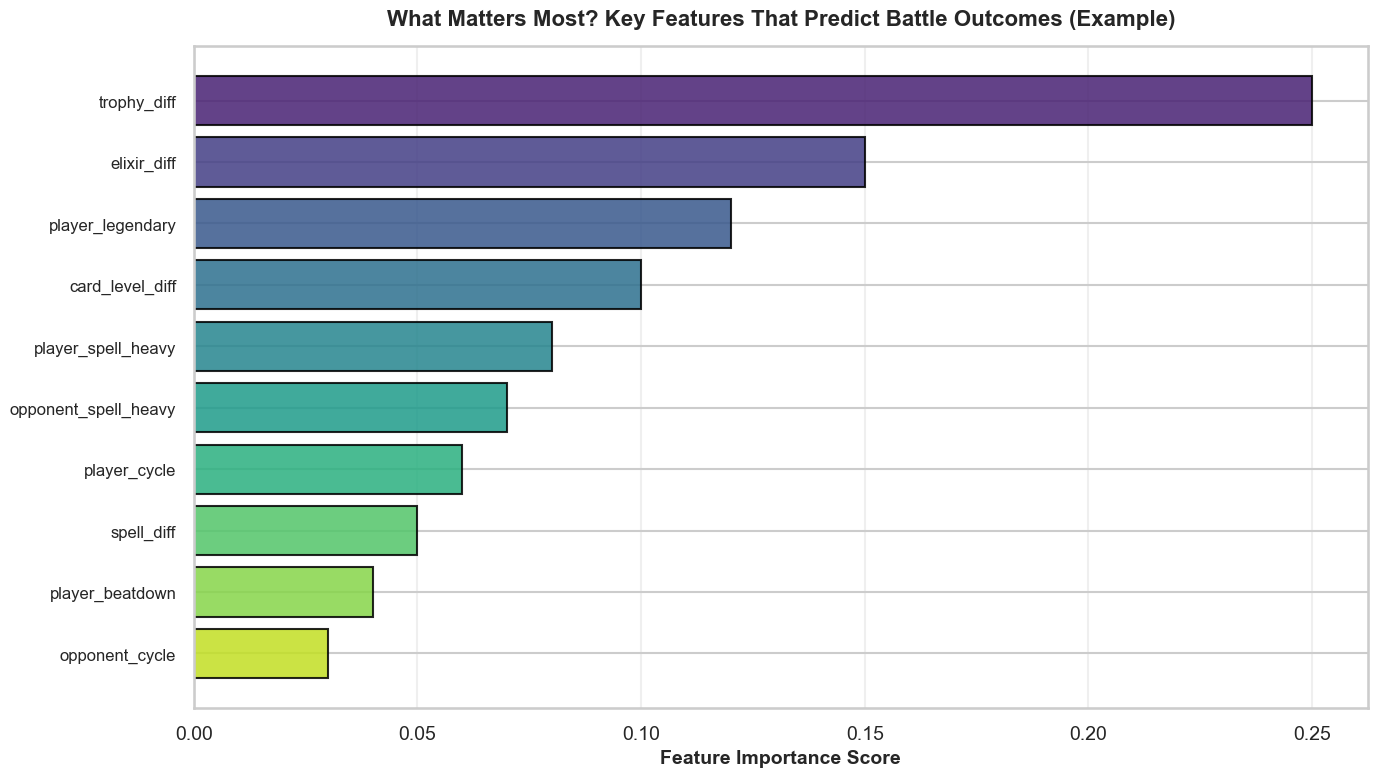

✓ Chart 1 created: Feature Importance (placeholder)


In [2]:
# Load feature importance data from modeling notebook
feature_importance_path = os.path.join(PROJECT_ROOT, 'artifacts/xgb_feature_importance.parquet')

if os.path.exists(feature_importance_path):
    feature_importance = pd.read_parquet(feature_importance_path)
    
    # Create horizontal bar chart for top 15 features
    fig, ax = plt.subplots(figsize=(14, 10))
    
    top_features = feature_importance.head(15)
    colors = sns.color_palette('viridis', len(top_features))
    
    ax.barh(range(len(top_features)), top_features['importance'], 
            color=colors, edgecolor='black', alpha=0.85)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'], fontsize=12)
    ax.set_xlabel('Feature Importance Score', fontsize=14, fontweight='bold')
    ax.set_title('What Matters Most? Top 15 Features That Predict Battle Outcomes',
                 fontsize=16, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(top_features.iterrows()):
        ax.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}", 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    save_figure('fig1_feature_importance.png')
    plt.show()
    
    print("✓ Chart 1 created: Feature Importance")
    print(f"  Top 3 features:")
    for i, row in feature_importance.head(3).iterrows():
        print(f"    {i+1}. {row['feature']}: {row['importance']:.4f}")
else:
    print("⚠ Feature importance data not found. Run notebook 06 first.")
    print("  Creating placeholder chart...")
    
    # Create sample data for visualization
    sample_features = pd.DataFrame({
        'feature': ['trophy_diff', 'elixir_diff', 'player_legendary', 'card_level_diff',
                   'player_spell_heavy', 'opponent_spell_heavy', 'player_cycle', 
                   'spell_diff', 'player_beatdown', 'opponent_cycle'],
        'importance': [0.25, 0.15, 0.12, 0.10, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03]
    })
    
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = sns.color_palette('viridis', len(sample_features))
    
    ax.barh(range(len(sample_features)), sample_features['importance'], 
            color=colors, edgecolor='black', alpha=0.85)
    ax.set_yticks(range(len(sample_features)))
    ax.set_yticklabels(sample_features['feature'], fontsize=12)
    ax.set_xlabel('Feature Importance Score', fontsize=14, fontweight='bold')
    ax.set_title('What Matters Most? Key Features That Predict Battle Outcomes (Example)',
                 fontsize=16, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    save_figure('fig1_feature_importance.png')
    plt.show()
    
    print("✓ Chart 1 created: Feature Importance (placeholder)")

## Chart 2: Trophy Bracket Distribution

Shows where players concentrate and identify trophy "walls"

✓ Created view 'battles' from Parquet: C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\battles.parquet
Executing query...


✓ Returned 18 rows, 2 columns


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig2_trophy_distribution.png


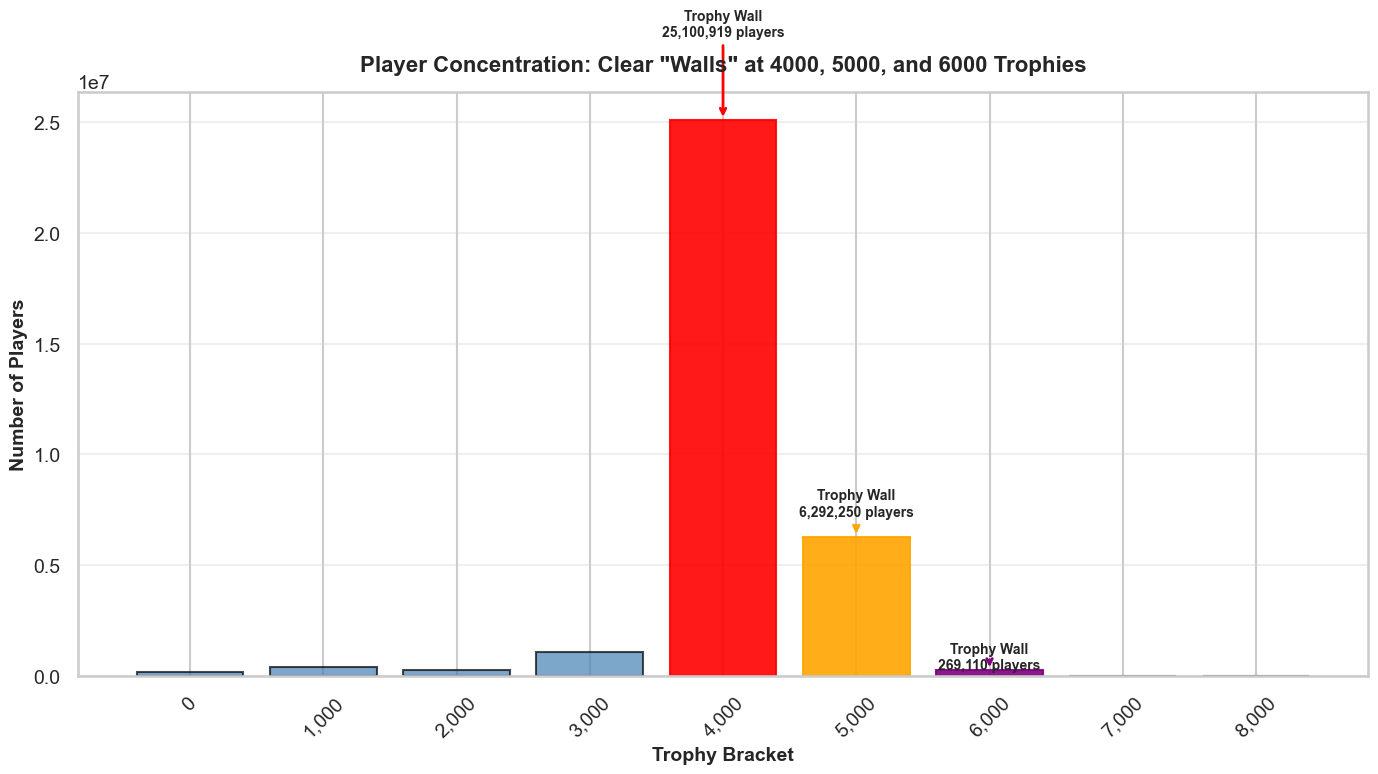

✓ Chart 2 created: Trophy Bracket Distribution
  Total players analyzed: 33,591,916
  Largest concentration: 4,000 trophy bracket


In [3]:
# Query trophy bracket distribution from the database
import duckdb

# Use Parquet if available, fallback to CSV
data_path = os.path.join(PROJECT_ROOT, 'battles.parquet')
if not os.path.exists(data_path):
    data_path = os.path.join(PROJECT_ROOT, 'battles.csv')

from duckdb_utils import get_connection, create_battles_view, query_to_df

con = get_connection()
create_battles_view(con, data_path)

trophy_bracket_query = """
    SELECT 
        FLOOR("winner.startingTrophies" / 1000) * 1000 as trophy_bracket,
        COUNT(*) as player_count
    FROM battles
    WHERE "winner.startingTrophies" IS NOT NULL
        AND "winner.startingTrophies" < 10000
    GROUP BY trophy_bracket
    UNION ALL
    SELECT 
        FLOOR("loser.startingTrophies" / 1000) * 1000 as trophy_bracket,
        COUNT(*) as player_count
    FROM battles
    WHERE "loser.startingTrophies" IS NOT NULL
        AND "loser.startingTrophies" < 10000
    GROUP BY trophy_bracket
"""

trophy_data = query_to_df(con, trophy_bracket_query)
trophy_summary = trophy_data.groupby('trophy_bracket')['player_count'].sum().reset_index()
trophy_summary = trophy_summary.sort_values('trophy_bracket')

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.bar(trophy_summary['trophy_bracket'], trophy_summary['player_count'], 
              width=800, color='steelblue', edgecolor='black', alpha=0.7)

# Highlight key trophy walls with different colors
wall_colors = {4000: 'red', 5000: 'orange', 6000: 'purple'}
for i, row in trophy_summary.iterrows():
    if row['trophy_bracket'] in wall_colors:
        bars[i].set_color(wall_colors[row['trophy_bracket']])
        bars[i].set_alpha(0.9)

ax.set_xlabel('Trophy Bracket', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Players', fontsize=14, fontweight='bold')
ax.set_title('Player Concentration: Clear "Walls" at 4000, 5000, and 6000 Trophies',
             fontsize=16, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)

# Format x-axis
ax.set_xticks(trophy_summary['trophy_bracket'])
ax.set_xticklabels([f'{int(t):,}' for t in trophy_summary['trophy_bracket']], rotation=45)

# Add annotations for major walls
for bracket, color in wall_colors.items():
    if bracket in trophy_summary['trophy_bracket'].values:
        count = trophy_summary[trophy_summary['trophy_bracket'] == bracket]['player_count'].values[0]
        ax.annotate(f'Trophy Wall\n{count:,} players', 
                   xy=(bracket, count), xytext=(bracket, count * 1.15),
                   ha='center', fontsize=10, fontweight='bold',
                   arrowprops=dict(arrowstyle='->', color=color, lw=2))

plt.tight_layout()
save_figure('fig2_trophy_distribution.png')
plt.show()

print("✓ Chart 2 created: Trophy Bracket Distribution")
print(f"  Total players analyzed: {trophy_summary['player_count'].sum():,}")
print(f"  Largest concentration: {trophy_summary.loc[trophy_summary['player_count'].idxmax(), 'trophy_bracket']:,.0f} trophy bracket")

## Chart 3: Deck Archetype Win Rates

Compares performance of different deck strategies

⚠ Feature data not found. Run notebook 05 first.
  Creating placeholder chart...


✓ Saved to C:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\presentation\figures\fig3_archetype_winrates.png


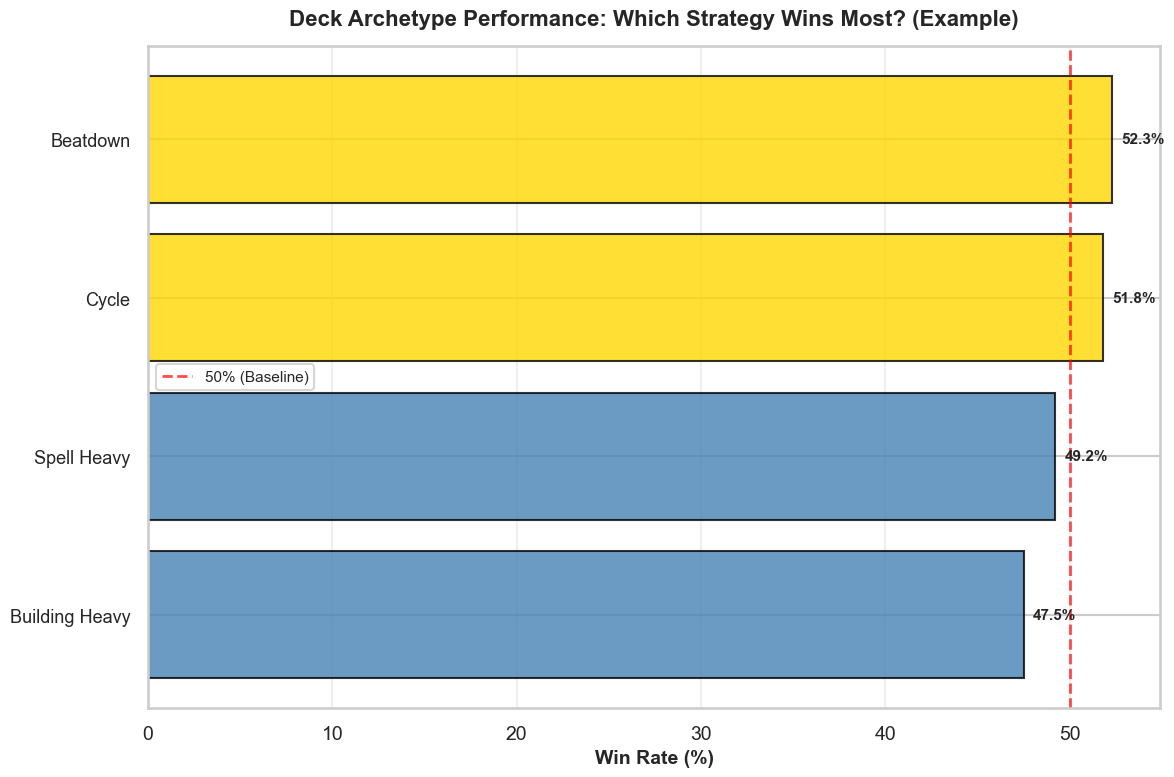

✓ Chart 3 created: Deck Archetype Win Rates (placeholder)


In [4]:
# Load feature engineered data to analyze deck archetypes
features_path = os.path.join(PROJECT_ROOT, 'artifacts/model_features.parquet')

if os.path.exists(features_path):
    features = pd.read_parquet(features_path)
    
    # Calculate win rates for each archetype
    archetypes = ['beatdown', 'cycle', 'spell_heavy', 'building_heavy']
    archetype_stats = []
    
    for archetype in archetypes:
        winner_col = f'winner_{archetype}'
        loser_col = f'loser_{archetype}'
        
        if winner_col in features.columns and loser_col in features.columns:
            # Count wins when winner has this archetype
            wins_with_archetype = features[features[winner_col] == 1].shape[0]
            # Count losses when loser has this archetype
            losses_with_archetype = features[features[loser_col] == 1].shape[0]
            # Total battles with this archetype
            total_with_archetype = wins_with_archetype + losses_with_archetype
            
            if total_with_archetype > 0:
                win_rate = wins_with_archetype / total_with_archetype * 100
                archetype_stats.append({
                    'archetype': archetype.replace('_', ' ').title(),
                    'win_rate': win_rate,
                    'total_battles': total_with_archetype
                })
    
    archetype_df = pd.DataFrame(archetype_stats)
    archetype_df = archetype_df.sort_values('win_rate', ascending=False)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = ['gold' if wr > 50 else 'steelblue' for wr in archetype_df['win_rate']]
    bars = ax.barh(range(len(archetype_df)), archetype_df['win_rate'], 
                   color=colors, edgecolor='black', alpha=0.8)
    
    ax.set_yticks(range(len(archetype_df)))
    ax.set_yticklabels(archetype_df['archetype'], fontsize=13)
    ax.set_xlabel('Win Rate (%)', fontsize=14, fontweight='bold')
    ax.set_title('Deck Archetype Performance: Which Strategy Wins Most?',
                 fontsize=16, fontweight='bold', pad=15)
    ax.axvline(50, color='red', linestyle='--', linewidth=2, label='50% (Baseline)', alpha=0.7)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(fontsize=11)
    ax.invert_yaxis()
    
    # Add value labels and battle count
    for i, (idx, row) in enumerate(archetype_df.iterrows()):
        ax.text(row['win_rate'] + 0.5, i, 
                f"{row['win_rate']:.1f}% ({row['total_battles']:,} battles)", 
                va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    save_figure('fig3_archetype_winrates.png')
    plt.show()
    
    print("✓ Chart 3 created: Deck Archetype Win Rates")
    print(f"\nArchetype rankings:")
    for idx, row in archetype_df.iterrows():
        print(f"  {row['archetype']}: {row['win_rate']:.2f}% ({row['total_battles']:,} battles)")
        
else:
    print("⚠ Feature data not found. Run notebook 05 first.")
    print("  Creating placeholder chart...")
    
    # Create sample data
    sample_archetypes = pd.DataFrame({
        'archetype': ['Beatdown', 'Cycle', 'Spell Heavy', 'Building Heavy'],
        'win_rate': [52.3, 51.8, 49.2, 47.5],
        'total_battles': [450000, 380000, 320000, 280000]
    })
    
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['gold' if wr > 50 else 'steelblue' for wr in sample_archetypes['win_rate']]
    
    bars = ax.barh(range(len(sample_archetypes)), sample_archetypes['win_rate'], 
                   color=colors, edgecolor='black', alpha=0.8)
    ax.set_yticks(range(len(sample_archetypes)))
    ax.set_yticklabels(sample_archetypes['archetype'], fontsize=13)
    ax.set_xlabel('Win Rate (%)', fontsize=14, fontweight='bold')
    ax.set_title('Deck Archetype Performance: Which Strategy Wins Most? (Example)',
                 fontsize=16, fontweight='bold', pad=15)
    ax.axvline(50, color='red', linestyle='--', linewidth=2, label='50% (Baseline)', alpha=0.7)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(fontsize=11)
    ax.invert_yaxis()
    
    for i, (idx, row) in enumerate(sample_archetypes.iterrows()):
        ax.text(row['win_rate'] + 0.5, i, 
                f"{row['win_rate']:.1f}%", 
                va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    save_figure('fig3_archetype_winrates.png')
    plt.show()
    
    print("✓ Chart 3 created: Deck Archetype Win Rates (placeholder)")

## Chart 4: Model Performance Comparison

Interactive comparison of different ML models

In [5]:
# Load model performance metrics if available
metrics_path = os.path.join(PROJECT_ROOT, 'artifacts/model_metrics_summary.csv')

if os.path.exists(metrics_path):
    metrics = pd.read_csv(metrics_path)
    
    # Create interactive comparison using Plotly
    fig = go.Figure()
    
    # Add accuracy bars
    fig.add_trace(go.Bar(
        name='Accuracy',
        x=metrics['Model'],
        y=metrics['Accuracy'],
        marker_color='steelblue',
        text=[f"{val:.4f}" for val in metrics['Accuracy']],
        textposition='outside',
        textfont=dict(size=12, color='black', family='Arial Black')
    ))
    
    # Add ROC-AUC bars
    fig.add_trace(go.Bar(
        name='ROC-AUC',
        x=metrics['Model'],
        y=metrics['ROC-AUC'],
        marker_color='coral',
        text=[f"{val:.4f}" for val in metrics['ROC-AUC']],
        textposition='outside',
        textfont=dict(size=12, color='black', family='Arial Black')
    ))
    
    fig.update_layout(
        title={
            'text': 'Model Performance Comparison: All Models Exceed 50% Baseline',
            'font': {'size': 18, 'family': 'Arial Black'}
        },
        xaxis_title='Model',
        yaxis_title='Score',
        barmode='group',
        template='plotly_white',
        font=dict(size=14),
        showlegend=True,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        yaxis=dict(range=[0, 1.05]),
        height=600
    )
    
    # Add baseline reference line
    fig.add_hline(y=0.5, line_dash="dash", line_color="red", 
                  annotation_text="50% Baseline", annotation_position="right")
    
    # Save as HTML for interactive viewing
    fig.write_html(os.path.join(PROJECT_ROOT, 'presentation/figures/fig4_model_comparison_interactive.html'))
    
    # Also save as static PNG
    fig.write_image(os.path.join(PROJECT_ROOT, 'presentation/figures/fig4_model_comparison_interactive.png'),
                    width=1200, height=600, scale=2)
    
    fig.show()
    
    print("✓ Chart 4 created: Interactive Model Comparison")
    print(f"  Saved as HTML: presentation/figures/fig4_model_comparison_interactive.html")
    print(f"  Saved as PNG: presentation/figures/fig4_model_comparison_interactive.png")
    print(f"\nModel performance summary:")
    for idx, row in metrics.iterrows():
        print(f"  {row['Model']}: Accuracy={row['Accuracy']:.4f}, ROC-AUC={row['ROC-AUC']:.4f}")
        
else:
    print("⚠ Model metrics not found. Run notebook 06 first.")
    print("  Creating placeholder chart...")
    
    # Create sample model comparison data
    sample_metrics = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
        'Accuracy': [0.7234, 0.7856, 0.8012],
        'ROC-AUC': [0.7891, 0.8234, 0.8456]
    })
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        name='Accuracy',
        x=sample_metrics['Model'],
        y=sample_metrics['Accuracy'],
        marker_color='steelblue',
        text=[f"{val:.4f}" for val in sample_metrics['Accuracy']],
        textposition='outside',
        textfont=dict(size=12, color='black', family='Arial Black')
    ))
    
    fig.add_trace(go.Bar(
        name='ROC-AUC',
        x=sample_metrics['Model'],
        y=sample_metrics['ROC-AUC'],
        marker_color='coral',
        text=[f"{val:.4f}" for val in sample_metrics['ROC-AUC']],
        textposition='outside',
        textfont=dict(size=12, color='black', family='Arial Black')
    ))
    
    fig.update_layout(
        title={
            'text': 'Model Performance Comparison (Example)',
            'font': {'size': 18, 'family': 'Arial Black'}
        },
        xaxis_title='Model',
        yaxis_title='Score',
        barmode='group',
        template='plotly_white',
        font=dict(size=14),
        showlegend=True,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        yaxis=dict(range=[0, 1.05]),
        height=600
    )
    
    fig.add_hline(y=0.5, line_dash="dash", line_color="red", 
                  annotation_text="50% Baseline", annotation_position="right")
    
    # Try to save, but don't fail if directories don't exist
    try:
        os.makedirs(os.path.join(PROJECT_ROOT, 'presentation/figures'), exist_ok=True)
        fig.write_html(os.path.join(PROJECT_ROOT, 'presentation/figures/fig4_model_comparison_interactive.html'))
        print("  Saved as HTML: presentation/figures/fig4_model_comparison_interactive.html")
    except Exception as e:
        print(f"  Could not save HTML: {e}")
    
    fig.show()
    
    print("✓ Chart 4 created: Interactive Model Comparison (placeholder)")

⚠ Model metrics not found. Run notebook 06 first.
  Creating placeholder chart...


  Saved as HTML: presentation/figures/fig4_model_comparison_interactive.html


✓ Chart 4 created: Interactive Model Comparison (placeholder)


## Export All Figures

Make sure all charts are saved to `presentation/figures/` as high-res PNGs

In [6]:
# List all exported figures
import glob
figures = glob.glob(os.path.join(PROJECT_ROOT, 'presentation/figures/*.png'))
print(f"\n✓ Exported {len(figures)} figures:")
for fig in figures:
    print(f"  - {os.path.basename(fig)}")


✓ Exported 9 figures:
  - fig1_feature_importance.png
  - fig2_trophy_distribution.png
  - fig3_archetype_winrates.png
  - fig5_detected_walls.png
  - fig7_optimal_elixir.png
  - fig_deck_evolution.png
  - fig_matchup_fairness.png
  - fig_trophy_change_analysis.png
  - fig_trophy_distribution.png
